# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных


Признаки

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

## Подготовка данных

In [ ]:
!pip install -qq catboost
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,  OrdinalEncoder,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_squared_error, r2_score, mean_absolute_error,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

In [ ]:
try:
   df =  pd.read_csv('/datasets/autos.csv')
except:
   df =  pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [ ]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Перевод к нужным типам данных

In [ ]:
#приведу столбы с датами из типа "object" к "datetime"
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')

Приведу названия столбов по стандарту snake_case

In [ ]:
df = df.rename(columns={'DateCrawled': 'date_crawled',
                        'Price': 'price',
                        'VehicleType': 'vehicle_type',
                        'RegistrationYear': 'registration_year',
                        'Gearbox' : 'grearbox',	
                        'Power':'power',
                        'Model':'model',
                        'Kilometer':'kilometer',
                        'RegistrationMonth': 'registration_month',
                        'FuelType': 'fuel_type',
                        'Brand':'brand',
                        'Repaired':'repaired',
                        'DateCreated': 'date_created',
                        'NumberOfPictures': 'number_of_pictures',
                        'PostalCode': 'postal_code',
                        'LastSeen': 'last_seen'})
df

,date_crawled,price,vehicle_type,registration_year,grearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


### Просмотр дубликатов, нулевых значений, пропусков

In [ ]:
df.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
grearbox              19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
for i in df[["fuel_type","repaired", "vehicle_type", "model", "grearbox"]]:
    df[i] = df[i].fillna("other")
df.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
grearbox              0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Нахождение аномальных значений и их удаление 

In [ ]:
for i in df:
    print(i,":")
    print(df[i].unique(), "\n")

date_crawled :
['2016-03-24T11:52:17.000000000' '2016-03-24T10:58:45.000000000'
 '2016-03-14T12:52:21.000000000' ... '2016-03-21T09:50:58.000000000'
 '2016-03-14T17:48:27.000000000' '2016-03-19T18:57:12.000000000'] 

price :
[  480 18300  9800 ... 12395 18429 10985] 

vehicle_type :
['other' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'] 

registration_year :
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 19

In [ ]:
df = df.query('registration_month > 0').reset_index(drop=True)

<AxesSubplot:>

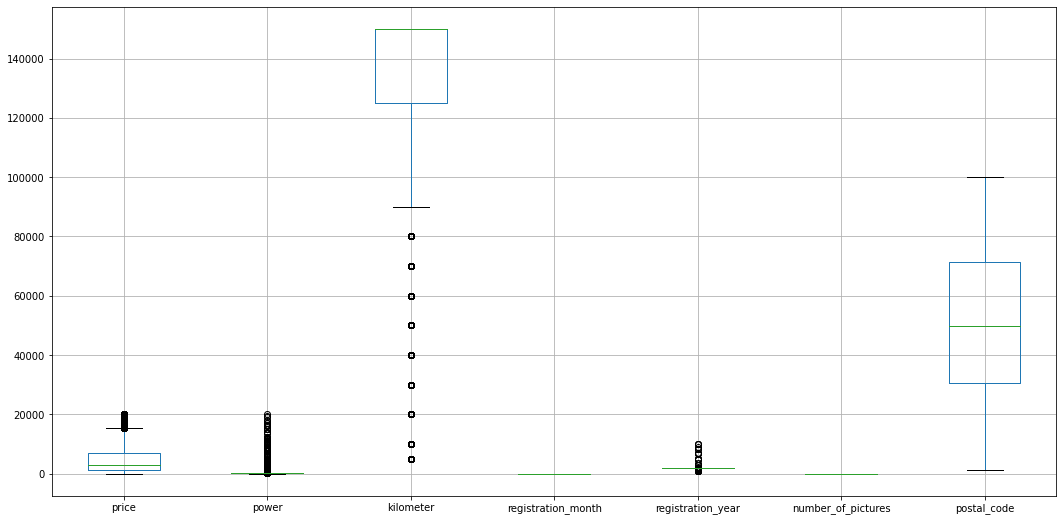

In [ ]:
df[['price','power','kilometer','registration_month','registration_year','number_of_pictures','postal_code',]]\
                                                                  .boxplot(figsize=(18,9))

In [ ]:
q3, q1 = np.percentile(df['price'], [75 ,25])
iqr = q3 - q1
print('Межквартильный размах: ', iqr)
print()
print('Первый квартиль: ', q1)
print()
print('Третий квартиль: ', q3)
print()

min = q1 - 1.5*iqr
max = q3 + 1.5*iqr

print('Минимум: ', min)
print()
print('Максимум: ', max)

Межквартильный размах:  5600.0

Первый квартиль:  1250.0

Третий квартиль:  6850.0

Минимум:  -7150.0

Максимум:  15250.0


Странно, что цена может быть отрицательной, удалю аномальные данные, которые меньше 0 

<AxesSubplot:>

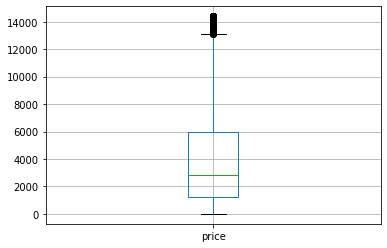

In [ ]:
df = df.query('price > 0 and price < 14425').reset_index(drop=True)
df[['price']].boxplot()

In [ ]:
q3, q1 = np.percentile(df['power'], [75 ,25])
iqr = q3 - q1
print('Межквартильный размах: ', iqr)
print()
print('Первый квартиль: ', q1)
print()
print('Третий квартиль: ', q3)
print()

min = q1 - 1.5*iqr
max = q3 + 1.5*iqr

print('Минимум: ', min)
print()
print('Максимум: ', max)

Межквартильный размах:  65.0

Первый квартиль:  75.0

Третий квартиль:  140.0

Минимум:  -22.5

Максимум:  237.5


<AxesSubplot:>

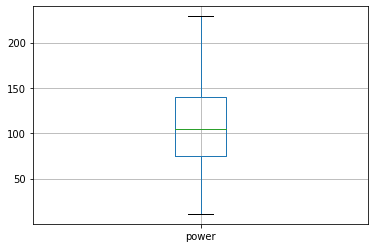

In [ ]:
df = df.query('power > 10 and power < 230').reset_index(drop=True)
df[['power']].boxplot()

In [ ]:
q3, q1 = np.percentile(df['registration_year'], [75 ,25])
iqr = q3 - q1
print('Межквартильный размах: ', iqr)
print()
print('Первый квартиль: ', q1)
print()
print('Третий квартиль: ', q3)
print()

min = q1 - 1.5*iqr
max = q3 + 1.5*iqr

print('Минимум: ', min)
print()
print('Максимум: ', max)

Межквартильный размах:  8.0

Первый квартиль:  1999.0

Третий квартиль:  2007.0

Минимум:  1987.0

Максимум:  2019.0


[1000 1234 1500 1800 1910 1928 1929 1931 1937 1938 1941 1942 1943 1945
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2800 2900 6500 8200]


<AxesSubplot:>

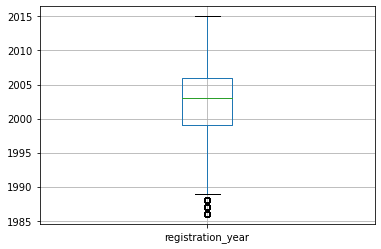

In [ ]:
print(np.sort(df['registration_year'].unique()))
df = df.query('registration_year > 1985 and registration_year < 2016').reset_index(drop=True)
df[['registration_year']].boxplot()

In [ ]:
print("Уникальные значения столба:" , df['number_of_pictures'].unique())
print(df['number_of_pictures'].describe())

Уникальные значения столба: [0]
count    244273.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64


удалю столбец, который не несет никакой важной информации 

In [ ]:
df = df.drop('number_of_pictures', axis=1)

In [ ]:
df.reset_index(drop=True)

,date_crawled,price,vehicle_type,registration_year,grearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,2016-03-14,90480,2016-04-05 12:47:46
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,67112,2016-04-05 18:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244268,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28,75223,2016-04-02 18:16:20
244269,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19,96465,2016-03-19 20:44:43
244270,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,26135,2016-03-11 18:17:12
244271,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,87439,2016-04-07 07:15:26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244273 entries, 0 to 244272
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        244273 non-null  datetime64[ns]
 1   price               244273 non-null  int64         
 2   vehicle_type        244273 non-null  object        
 3   registration_year   244273 non-null  int64         
 4   grearbox            244273 non-null  object        
 5   power               244273 non-null  int64         
 6   model               244273 non-null  object        
 7   kilometer           244273 non-null  int64         
 8   registration_month  244273 non-null  int64         
 9   fuel_type           244273 non-null  object        
 10  brand               244273 non-null  object        
 11  repaired            244273 non-null  object        
 12  date_created        244273 non-null  datetime64[ns]
 13  postal_code         244273 no

### Переведу столбы с категориальными признаками в численные: vehicle_type, model, fuel_type, brand, not_repaired. 

In [ ]:
# Функция проверяет данные. Возвращает предобработанные данные для обучения.
def get_preprocessed_data(df):
    # проверяем данные
    assert df.isna().sum().sum() == 0, "Не должно быть пропущенных значений!"
    assert df.select_dtypes(exclude=[np.float64, np.int64, np.object, np.datetime64]).size == 0,"Данные должны иметь только численный тип данных!"
    assert df.duplicated().sum().sum() == 0, "В данных не должно быть дубликатов!"
    print('все ок, данные норм!')
    #создаем копию оригинального датафрейма
    preprocessed_data = df.copy()
    return preprocessed_data
df_new = get_preprocessed_data(df)

все ок, данные норм!


In [ ]:
df_model = df_new.copy()

удалю столбцы, которые не нужны нам для обучения модели 

In [ ]:
df_model = df_model.drop(['date_crawled','date_created', 'postal_code', 'last_seen', 'registration_month'], axis=1)
df_model.head()

,price,vehicle_type,registration_year,grearbox,power,model,kilometer,fuel_type,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,other
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


### Разделим  данные на нужные тестовую и обучающую выборку

* Функция возвращает 1) целевой признак, 2) признаки без целевого
* data - данные которые необходимо разделить
* column - целевой признак

In [ ]:
random_state =  12345

In [ ]:
features = df_model.drop(['price'],axis=1)
target = df_model['price']

In [ ]:
features.columns

Index(['vehicle_type', 'registration_year', 'grearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [ ]:
col = ['vehicle_type', 'registration_year', 'grearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired']

In [ ]:
encoder = OrdinalEncoder()
encoder.fit(features[col])
features = features.copy()
features[col]= pd.DataFrame(encoder.transform(features[col]), columns = features[col].columns)

In [ ]:
features.head(3)

,vehicle_type,registration_year,grearbox,power,model,kilometer,fuel_type,brand,repaired
0,6.0,18.0,0.0,151.0,116.0,11.0,2.0,14.0,1.0
1,5.0,15.0,1.0,63.0,115.0,12.0,6.0,38.0,0.0
2,5.0,22.0,1.0,57.0,100.0,9.0,2.0,31.0,0.0


In [ ]:
def cross_val(target,features):
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=random_state,test_size=0.25)
    return features_train, target_train, features_test, target_test

In [ ]:
features_train_cross, target_train_cross, features_test_cross, target_test_cross = cross_val(target, features)

### Стандартиризируем данные, где  features_train - признаки обучающей выборки, features_test - признаки тестовой выборки

In [ ]:
def crossValStandardScaling(features_train, features_test):
    features_train_copy = features_train.copy()
    features_test_copy = features_test.copy()
    scaler = StandardScaler()
    # численные столбцы 
    numeric = ['power','registration_year', 'kilometer']
    # настраиваем на обучающей выборке
    scaler.fit(features_train_copy.loc[:,numeric])
    # преобразование выборки с помощью transform()
    features_train_copy.loc[:,numeric] = scaler.transform(features_train_copy.loc[:,numeric])
    features_test_copy.loc[:,numeric] = scaler.transform(features_test_copy.loc[:,numeric])
    return features_train_copy, features_test_copy

In [ ]:
features_train_cross, features_test_cross = crossValStandardScaling(features_train_cross, features_test_cross)

### По предварительной обработке было выявлено:
* названия столбов были переименованы по стандарту snake_case
* содержался столбец,который не нес важной информации, я его удалила
* удалены явные дубликаты
* price, kilometer, power содержали аномальные значения, которые я удалила 
* в столбцах содержатся пропуски: vehicle_type=37490, grearbox = 19833, model = 19705, fuel_type = 32895, repaired = 71154 были заменены 
* убрала из данных, на которых будут проводиться исследования столбы, которые не влиют на обучение
* провелось кодирование
* данные разделены с помощью кросс-валидации в отношении (75/25) на обучающую и тестовую выборку 
* масштабировала признаки с помощью стандартизации

## Обучение моделей

In [ ]:
ml_models_stats = dict()

In [ ]:
def evaluate_model(model_name, model,training_time,features_test, target_test,features_train, target_train,parameters=None):
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    predict_start = datetime.datetime.now()
    predicted_test = model.predict(features_test)
    predict_time = datetime.datetime.now() - predict_start
    mse_test = mean_squared_error(target_test, predicted_test)
    rmse_test = mse_test ** 0.5
    predicted_train = model.predict(features_train)
    mse_train = mean_squared_error(target_train, predicted_train)
    rmse_train = mse_train ** 0.5
    print(f'RMSE модели на обучающей выборке: {rmse_train}')
    print(f'RMSE модели на тестовой выборке: {rmse_test}')
    print(f'Время обучения модели: {training_time}')
    print(f'Время предсказания модели: {predict_time}')
    ml_models_stats[model_name] = {
        'название': model_name,
        'время_обучения': training_time,
        'время_предсказания':predict_time,
        'rmse_test':rmse_test,
        'rmse_train':rmse_train }

In [ ]:
def rmse(target,predictions):
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5

In [ ]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

### Дерево решений

In [ ]:
start = datetime.datetime.now()
decision_tree_model = DecisionTreeRegressor()
decision_parameters = {"max_depth": range(1, 11),"min_samples_leaf": range(1, 11)}
decision_grid =  RandomizedSearchCV(estimator=decision_tree_model, param_distributions=decision_parameters, cv=3,scoring=rmse_scorer, n_iter = 20, n_jobs=-1)
decision_grid.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start
evaluate_model('Дерево решений', decision_grid,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,decision_grid.best_params_)

Оценка модели: Дерево решений
с параметрами: {'min_samples_leaf': 8, 'max_depth': 10}
RMSE модели на обучающей выборке: 1457.8266968653793
RMSE модели на тестовой выборке: 1486.3326414124224
Время обучения модели: 0:00:08.276294
Время предсказания модели: 0:00:00.007043


In [ ]:
%%time
decision_grid.fit(features_train_cross,target_train_cross)

CPU times: user 7.37 s, sys: 22.1 ms, total: 7.4 s
Wall time: 7.4 s


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 11),
                                        'min_samples_leaf': range(1, 11)},
                   scoring=make_scorer(rmse, greater_is_better=False))

### Рандомный лес

In [ ]:
start = datetime.datetime.now()
random_forest_model = RandomForestRegressor()
gs_params = {'max_depth': range(1, 30),'n_estimators':range(1,70,10)}
forest_rs = RandomizedSearchCV(estimator=random_forest_model,param_distributions=gs_params,scoring=rmse_scorer,cv=5,n_iter = 20,n_jobs=-1)
forest_rs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start
evaluate_model('Рандомный лес', forest_rs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,forest_rs.best_params_)

Оценка модели: Рандомный лес
с параметрами: {'n_estimators': 51, 'max_depth': 20}
RMSE модели на обучающей выборке: 838.1879498143543
RMSE модели на тестовой выборке: 1215.6862939104103
Время обучения модели: 0:11:55.007719
Время предсказания модели: 0:00:00.817754


### LightGBM

In [ ]:
start = datetime.datetime.now()
lgb_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': [15,30],
    'num_leaves': [10,200,250]}
lgb_reg = lgb.LGBMRegressor()
lgb_gs = GridSearchCV(lgb_reg, lgb_params,scoring=rmse_scorer,n_jobs=-1)
lgb_gs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start
evaluate_model('LightGBM', lgb_gs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,lgb_gs.best_params_)

Оценка модели: LightGBM
с параметрами: {'boosting_type': 'goss', 'max_depth': 30, 'num_leaves': 250, 'objective': 'regression'}
RMSE модели на обучающей выборке: 1110.884506755396
RMSE модели на тестовой выборке: 1186.3048436250533
Время обучения модели: 0:23:16.140247
Время предсказания модели: 0:00:00.812007


### XGBoost

In [ ]:
start = datetime.datetime.now()
xgb_params = {"max_depth": range(3, 10,2), "min_child_weight": range(1,6,2)}
xgb = xgb.XGBRegressor(nthread=-1) 
xgb_gs = GridSearchCV(xgb, xgb_params, scoring=rmse_scorer,n_jobs=-1)
xgb_gs.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start
evaluate_model('XGBoost', xgb_gs,training_time,features_test_cross, target_test_cross,features_train_cross,target_train_cross,xgb_gs.best_params_)

Оценка модели: XGBoost
с параметрами: {'max_depth': 9, 'min_child_weight': 5}
RMSE модели на обучающей выборке: 1028.8133844603642
RMSE модели на тестовой выборке: 1187.2959792610766
Время обучения модели: 0:31:07.577229
Время предсказания модели: 0:00:00.309194


### CatBoost

In [ ]:
start = datetime.datetime.now()
catBoost_params = {
    'learning_rate': [1],
    'depth': [5, 6, 7, 8],
    'l2_leaf_reg': [1, 2, 3]
}
catBoost_reg = CatBoostRegressor(loss_function='RMSE',random_state=random_state,silent=True,eval_metric="RMSE")
catBoost_gs = GridSearchCV(catBoost_reg, catBoost_params,scoring=rmse_scorer,n_jobs=-1)
catBoost_gs.fit(features_train_cross,  target_train_cross)
training_time = datetime.datetime.now() - start
evaluate_model('CatBoost', catBoost_gs,training_time, features_test_cross, target_test_cross,features_train_cross,target_train_cross,catBoost_gs.best_params_)

Оценка модели: CatBoost
с параметрами: {'depth': 5, 'l2_leaf_reg': 3, 'learning_rate': 1}
RMSE модели на обучающей выборке: 1087.565722845029
RMSE модели на тестовой выборке: 1209.4122910060773
Время обучения модели: 0:20:16.417620
Время предсказания модели: 0:00:00.049648


### Проверка на адекватность Dummy

In [ ]:
start = datetime.datetime.now()
dummy_model = DummyRegressor(strategy="constant", constant=target_train_cross.median())
dummy_model.fit(features_train_cross,target_train_cross)
training_time = datetime.datetime.now() - start
evaluate_model('Дамми модель', dummy_model, training_time, features_test_cross, target_test_cross,features_train_cross,target_train_cross)

Оценка модели: Дамми модель
RMSE модели на обучающей выборке: 3632.634206765539
RMSE модели на тестовой выборке: 3620.195996420359
Время обучения модели: 0:00:00.004095
Время предсказания модели: 0:00:00.000353


## Анализ моделей

In [ ]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [ ]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

,название,время_обучения,время_предсказания,rmse_test,rmse_train
0,Дерево решений,0 days 00:00:08.276294,0 days 00:00:00.007043,1486.332641,1457.826697
1,Рандомный лес,0 days 00:11:55.007719,0 days 00:00:00.817754,1215.686294,838.187950
2,LightGBM,0 days 00:23:16.140247,0 days 00:00:00.812007,1186.304844,1110.884507
3,XGBoost,0 days 00:31:07.577229,0 days 00:00:00.309194,1187.295979,1028.813384
4,CatBoost,0 days 00:20:16.417620,0 days 00:00:00.049648,1209.412291,1087.565723
5,Дамми модель,0 days 00:00:00.004095,0 days 00:00:00.000353,3620.195996,3632.634207


In [ ]:
cool_models = ml_models.query("rmse_test < 2500")
cool_models

,название,время_обучения,время_предсказания,rmse_test,rmse_train
0,Дерево решений,0 days 00:00:08.276294,0 days 00:00:00.007043,1486.332641,1457.826697
1,Рандомный лес,0 days 00:11:55.007719,0 days 00:00:00.817754,1215.686294,838.187950
2,LightGBM,0 days 00:23:16.140247,0 days 00:00:00.812007,1186.304844,1110.884507
3,XGBoost,0 days 00:31:07.577229,0 days 00:00:00.309194,1187.295979,1028.813384
4,CatBoost,0 days 00:20:16.417620,0 days 00:00:00.049648,1209.412291,1087.565723


,название,rmse_test
0,LightGBM,1186.304844
1,XGBoost,1187.295979
2,CatBoost,1209.412291
3,Рандомный лес,1215.686294
4,Дерево решений,1486.332641


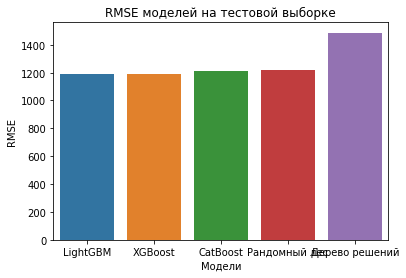

In [ ]:
rmse_test_sorted = cool_models.sort_values(by='rmse_test',ascending=True).reset_index()
display(rmse_test_sorted[['название','rmse_test']])
drawPlot(rmse_test_sorted, 'название','rmse_test','Модели','RMSE','RMSE моделей на тестовой выборке','название' )

In [ ]:
cool_models.query('название == "LightGBM"')

,название,время_обучения,время_предсказания,rmse_test,rmse_train
2,LightGBM,0 days 00:23:16.140247,0 days 00:00:00.812007,1186.304844,1110.884507


### Вывод по работе

По предварительной обработке было выявлено:
    
    
* названия столбов были переименованы по стандарту snake_case
* содержался столбец,который не нес важной информации, я его удалила
* удалены явные дубликаты
* price, kilometer, power содержали аномальные значения, которые я удалила 
* в столбцах содержатся пропуски: vehicle_type=37490, grearbox = 19833, model = 19705, fuel_type = 32895, repaired = 71154 были заменены 
* убрала из данных, на которых будут проводиться исследования столбы, которые не влиют на обучение
* провелось кодирование
* данные разделены с помощью кросс-валидации в отношении (75/25) на обучающую и тестовую выборку 
* масштабировала признаки с помощью стандартизации

Итоги моделей машинного обучения:

* были подобраны параметры с помощью GridSearchCV
* линейная регрессия, дерево решений, рандомный лес, XGBoost, LightGBM, CatBoost использовались в проекте 


Провели анализ скорости и точности моделей:

* была проведена проверка с помощью Dummy, все модели прошли тест.
* основываясь на том, что RMSE должно быть меньше 2500, была выбраналучшую модель - LightGBM.